In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import time
import scipy
import sklearn
import copy
import pickle
import os

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef

In [3]:
types = ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

## Read top10 DEGs

In [5]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level1/DEG_L1/DEG_table')

DEG_top10_dict = {}
for celltype in types:
    n_features = 10
    DEG_table = pd.read_csv(celltype + '_DEG1000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist()
    DEG_top10_dict[celltype] = DEGn

## Read datasets

In [8]:
adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/batch_corrected/Hao_PBMC_Harmony_unscaled.h5ad')
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')
labels = adata.obs['celltype.l1']
types = np.unique(labels).tolist()
types

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

In [9]:
# Read Zheng query dataset
query_adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_68k_Zheng/Zheng_PBMC.h5ad')
print(query_adata.shape)

# change Zheng query dataset var index from ensemble to gene symbol
query_adata_sym = copy.deepcopy(query_adata)
query_adata_sym.var['ensembl'] = query_adata_sym.var.index.tolist()
query_adata_sym.var.index = query_adata_sym.var['gene_symbols'].tolist()
query_adata_sym.var_names_make_unique()
query_adata_sym.var.head()

(68579, 32738)


gene_symbols          ensembl
MIR1302-10      MIR1302-10  ENSG00000243485
FAM138A            FAM138A  ENSG00000237613
OR4F5                OR4F5  ENSG00000186092
RP11-34P13.7  RP11-34P13.7  ENSG00000238009
RP11-34P13.8  RP11-34P13.8  ENSG00000239945

## Make prediction and get likelihood

In [10]:
def DEG_LR_classifier(data, DEGn, celltype):
    # subset data to DEGs
    X = data[:, DEGn].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    return clf


def predict_celltype_w_symbol(LR_model, query_adata, DEGn, celltype):
    # top DEGs
    train_genes = DEGn

    # Find intersection of train_genes and query_genes
    query_genes = query_adata.var_names.tolist()
    common_genes = list(set(train_genes) & set(query_genes))
    print('No. common genes:', len(common_genes))

    # Create a full matrix for query data, initializing with zeros for missing genes
    X_query_full = np.zeros((query_adata.shape[0], len(train_genes)))
    # Fill in the values for the common genes
    for i, gene in enumerate(train_genes):
        if gene in common_genes:
            X_query_full[:, i] = query_adata[:, gene].X.toarray().flatten()

    # predict on query dataset
    y_query_pred = LR_model.predict(X_query_full)
    print('Prediction = 1:', sum(y_query_pred == 1))  # predict celltype 的有幾個

    # Get the probability of individual cell predicting as the positive class
    y_query_prob = LR_model.predict_proba(X_query_full)[:, 1]  # Probability for the positive class (class 1)
    print('Probability > 0.5:', sum(y_query_prob > 0.5))  # >0.5: predict celltype, <0.5: predict not celltype

    return y_query_pred, y_query_prob

In [12]:
prediction_dict = {}
likelihood_dict = {}

for celltype in types:
    print(celltype, '=====================')
    DEGn = DEG_top10_dict[celltype]

    # Train classifier for each celltype on the top 10 DEGs on Hao dataset
    lr_celltype = DEG_LR_classifier(adata, DEGn, celltype)

    # Predict on Zheng query dataset
    y_pred_celltype, y_prob_celltype = predict_celltype_w_symbol(lr_celltype, query_adata_sym, DEGn, celltype)
    prediction_dict[celltype] = y_pred_celltype
    likelihood_dict[celltype] = y_prob_celltype

B =====================
No. common genes: 10
Prediction = 1: 6133
Probability > 0.5: 6133
CD4_T =====================
No. common genes: 10
Prediction = 1: 39341
Probability > 0.5: 39341
CD8_T =====================
No. common genes: 8
Prediction = 1: 47325
Probability > 0.5: 47325
DC =====================
No. common genes: 10
Prediction = 1: 7797
Probability > 0.5: 7797
Mono =====================
No. common genes: 10
Prediction = 1: 6464
Probability > 0.5: 6464
NK =====================
No. common genes: 10
Prediction = 1: 6511
Probability > 0.5: 6511
other =====================
No. common genes: 9
Prediction = 1: 206
Probability > 0.5: 206
other_T =====================
No. common genes: 10
Prediction = 1: 4318
Probability > 0.5: 4318


In [13]:
prediction_df = pd.DataFrame(prediction_dict)
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.head()

B     CD4_T     CD8_T            DC      Mono        NK     other  \
0  0.000053  0.953339  0.999748  4.138618e-11  0.000002  0.001548  0.001232   
1  0.000024  0.001619  0.999794  6.591157e-09  0.000115  0.000129  0.001232   
2  0.000623  0.999996  0.972274  6.591157e-09  0.000260  0.000150  0.001232   
3  1.000000  0.465686  0.816908  1.000000e+00  0.000027  0.000293  0.001232   
4  0.000053  1.000000  0.936113  2.178306e-11  0.000002  0.000129  0.001232   

    other_T  
0  0.114818  
1  0.001525  
2  0.000639  
3  0.000375  
4  0.070468

In [14]:
prediction_df.head()

B  CD4_T  CD8_T  DC  Mono  NK  other  other_T
0  0      1      1   0     0   0      0        0
1  0      0      1   0     0   0      0        0
2  0      1      1   0     0   0      0        0
3  1      0      1   1     0   0      0        0
4  0      1      1   0     0   0      0        0

In [15]:
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Zheng/Predict_w_Hao_LR')

# prediction_df.to_csv('predict_w_Hao_PreLect_top50_predictions.csv')
# likelihood_df.to_csv('predict_w_Hao_PreLect_top50_likelihood.csv')

In [16]:
prediction_df.sum(axis=0)

B           6133
CD4_T      39341
CD8_T      47325
DC          7797
Mono        6464
NK          6511
other        206
other_T     4318
dtype: int64

In [17]:
likelihood_df.sum(axis=1)

0        2.070739
1        1.004437
2        1.975174
3        3.284521
4        2.007995
           ...   
68574    1.969057
68575    2.046986
68576    0.502982
68577    0.009949
68578    1.999038
Length: 68579, dtype: float64

In [18]:
query_adata_sym.obs['celltype'].value_counts()

celltype
CD8+ Cytotoxic T                20773
CD8+/CD45RA+ Naive Cytotoxic    16666
CD56+ NK                         8776
CD4+/CD25 T Reg                  6187
CD19+ B                          5908
CD4+/CD45RO+ Memory              3061
CD14+ Monocyte                   2862
Dendritic                        2099
CD4+/CD45RA+/CD25- Naive T       1873
CD34+                             277
CD4+ T Helper2                     97
Name: count, dtype: int64

## Plot likelihood on UMAP

In [19]:
# Concatenate the likelihood_df with the adata.obs
likelihood_df.index = query_adata_sym.obs_names
query_adata_sym.obs = pd.concat([query_adata_sym.obs, likelihood_df], axis=1)
query_adata_sym.obs.head()

celltype     TSNE.1     TSNE.2  \
AAACATACACCCAA-1              CD8+ Cytotoxic T   7.565540   0.441370   
AAACATACCCCTCA-1  CD8+/CD45RA+ Naive Cytotoxic   2.552626 -25.786672   
AAACATACCGGAGA-1           CD4+/CD45RO+ Memory  -5.771831  11.830846   
AAACATACTAACCG-1                       CD19+ B   1.762556  25.979346   
AAACATACTCTTCA-1               CD4+/CD25 T Reg -16.793856 -16.589970   

                         B     CD4_T     CD8_T            DC      Mono  \
AAACATACACCCAA-1  0.000053  0.953339  0.999748  4.138618e-11  0.000002   
AAACATACCCCTCA-1  0.000024  0.001619  0.999794  6.591157e-09  0.000115   
AAACATACCGGAGA-1  0.000623  0.999996  0.972274  6.591157e-09  0.000260   
AAACATACTAACCG-1  1.000000  0.465686  0.816908  1.000000e+00  0.000027   
AAACATACTCTTCA-1  0.000053  1.000000  0.936113  2.178306e-11  0.000002   

                        NK     other   other_T  
AAACATACACCCAA-1  0.001548  0.001232  0.114818  
AAACATACCCCTCA-1  0.000129  0.001232  0.001525  
AAACATACCGGAGA-1  0.000150  0.001232  0.000639  
AAACATACTAACCG-1  0.000293  0.001232  0.000375  
AAACATACTCTTCA-1  0.000129  0.001232  0.070468

(68579, 32738)
(68579, 2000)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


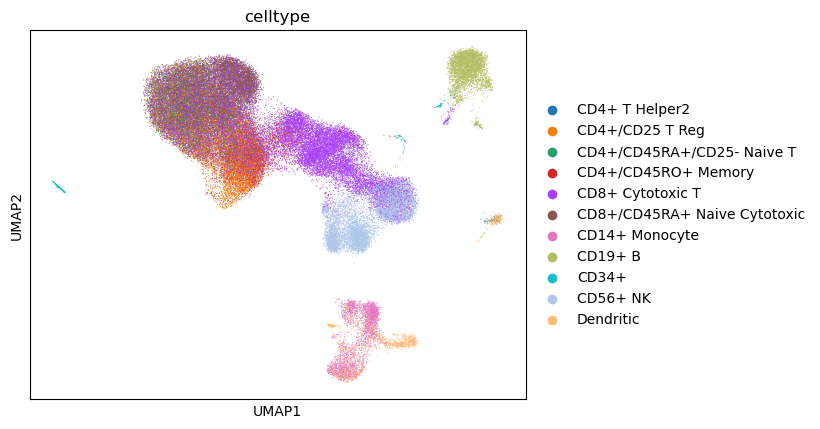

In [20]:
# Get UMAP embedding
query_adata_sym_copy = copy.deepcopy(query_adata_sym)
print(query_adata_sym_copy.shape)

# Normalization
sc.pp.normalize_total(query_adata_sym_copy, target_sum=None)
sc.pp.log1p(query_adata_sym_copy)

# HVG2000
sc.pp.highly_variable_genes(query_adata_sym_copy, n_top_genes=2000)
# filtering HVG2000
query_adata_sym_copy = query_adata_sym_copy[:, query_adata_sym_copy.var.highly_variable]
print(query_adata_sym_copy.shape)

# PCA
sc.tl.pca(query_adata_sym_copy, svd_solver='arpack')

# Neighboring graph
sc.pp.neighbors(query_adata_sym_copy, n_neighbors=10, n_pcs=50)
sc.tl.umap(query_adata_sym_copy)
sc.pl.umap(query_adata_sym_copy, color='celltype')

/var/folders/t1/zclr_f3s57j185f2tblqgwt00000gn/T/ipykernel_30891/1356671569.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(query_adata_sym_copy, resolution=0.9)


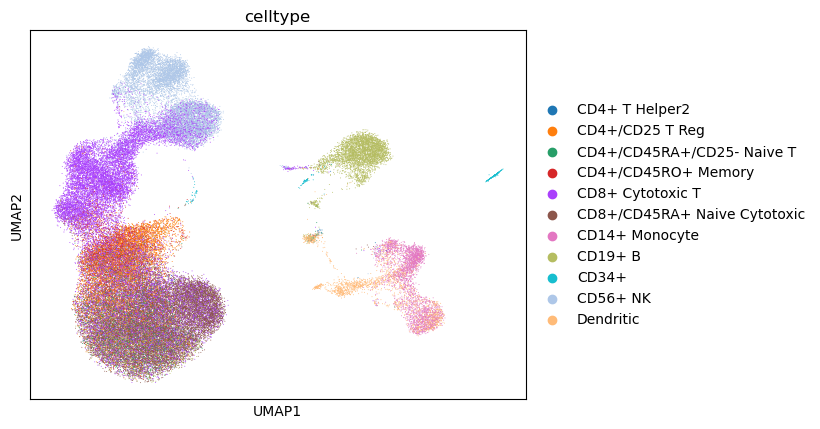

In [21]:
# Leiden and PAGA
sc.tl.leiden(query_adata_sym_copy, resolution=0.9)
sc.tl.paga(query_adata_sym_copy)
sc.pl.paga(query_adata_sym_copy, plot=False)
sc.tl.umap(query_adata_sym_copy, init_pos='paga')
sc.pl.umap(query_adata_sym_copy, color='celltype')

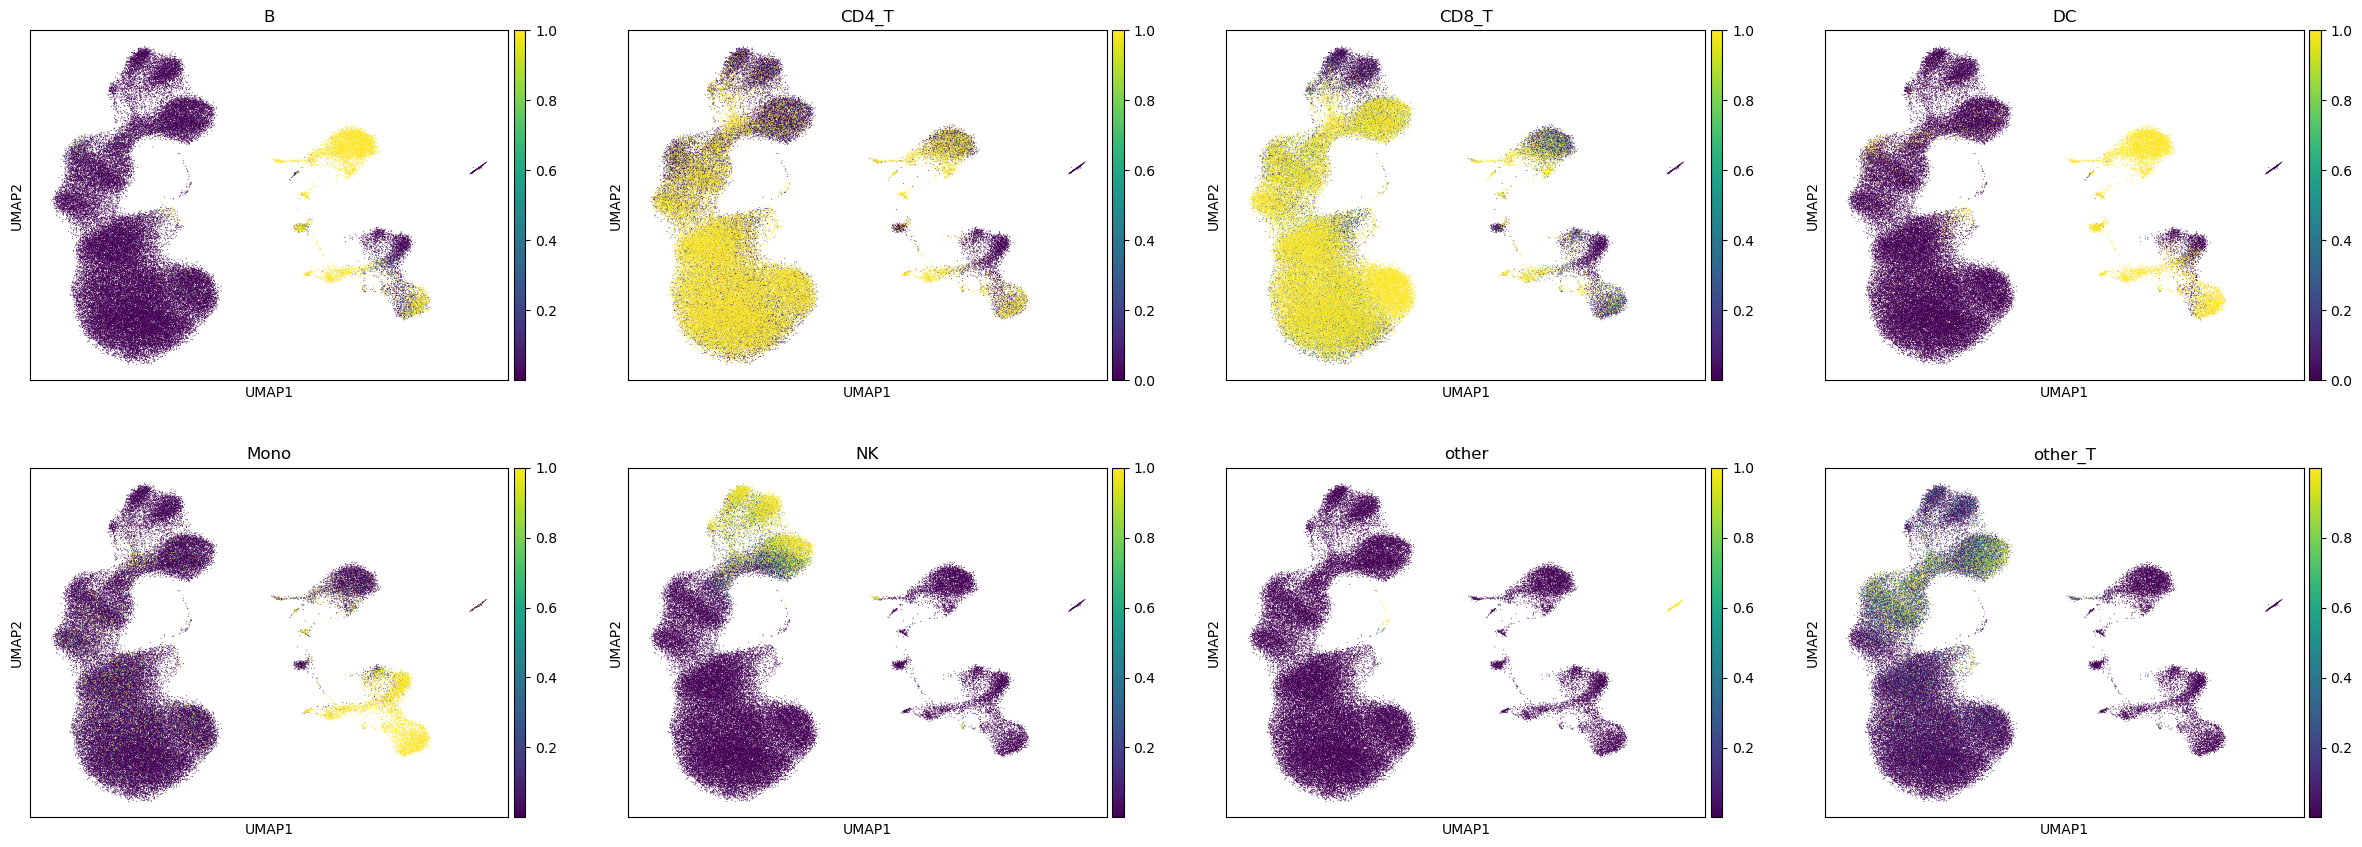

In [22]:
sc.pl.umap(query_adata_sym_copy, color=types)

## Plot likelihood on tSNE

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

obs = query_adata_sym.obs
tsne_embedding = obs[['TSNE.1', 'TSNE.2']]
tsne_embedding.head()

TSNE.1     TSNE.2
AAACATACACCCAA-1   7.565540   0.441370
AAACATACCCCTCA-1   2.552626 -25.786672
AAACATACCGGAGA-1  -5.771831  11.830846
AAACATACTAACCG-1   1.762556  25.979346
AAACATACTCTTCA-1 -16.793856 -16.589970

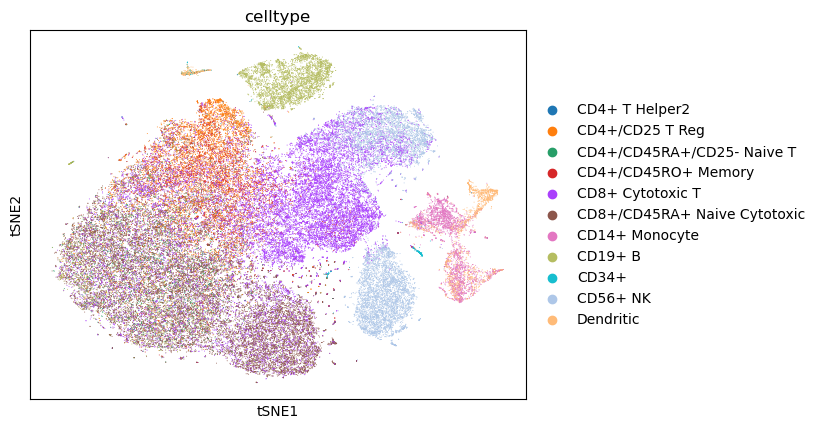

In [24]:
# store the tsne embedding in adata
query_adata_sym_copy.obsm['X_tsne'] = tsne_embedding.values
sc.pl.tsne(query_adata_sym_copy, color='celltype')

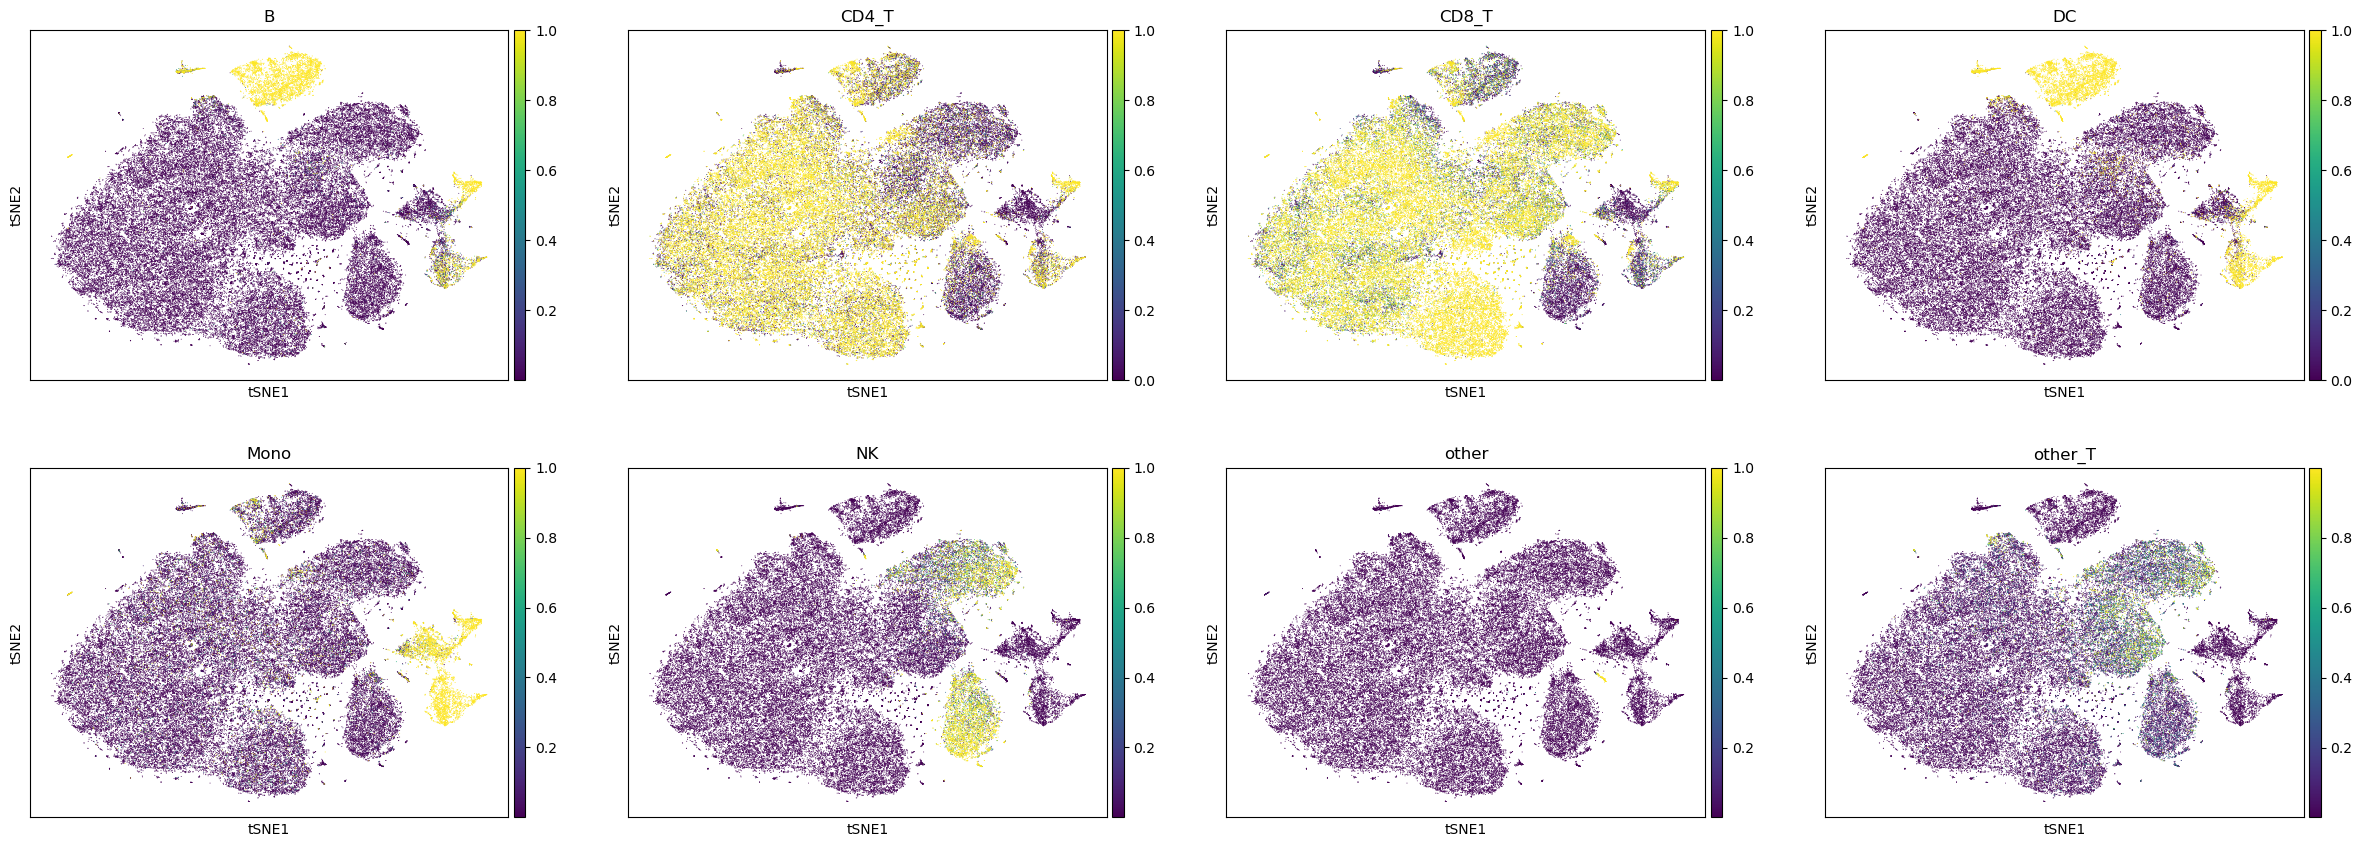

In [25]:
sc.pl.tsne(query_adata_sym_copy, color=types)